___
# Light GBM
___
Le "growing" (croissance) dans le contexte des arbres de décision fait référence au processus de construction de l'arbre à partir de la racine jusqu'aux feuilles. Plus précisément, il s'agit d'ajouter des nœuds à l'arbre de manière itérative, en choisissant à chaque étape la meilleure variable et le meilleur seuil pour diviser les données. Ce processus se poursuit jusqu'à ce qu'une condition d'arrêt soit atteinte, telle que la profondeur maximale de l'arbre ou le nombre minimal d'observations dans une feuille. En résumé, le growing dans les arbres de décision consiste à développer l'arbre de haut en bas en prenant des décisions sur les divisions optimales à chaque niveau.

## sources
* https://www.youtube.com/watch?v=n_ZMQj09S6w
* https://github.com/microsoft/LightGBM
* https://lightgbm.readthedocs.io/en/stable/

*Code récupéré ici :*
https://github.com/bnsreenu/python_for_microscopists/blob/master/196_lightGBM_feature_selection_breast_cancer.py

Les commentaires en anglais ne sont pas traduits

* **@author: Sreenivas Bhattiprolu**
* LGBM and how it compares to XGBoost
* https://lightgbm.readthedocs.io/en/latest/
* pip install lightgbm
* Dataset: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
* https://youtu.be/n_ZMQj09S6w


___
## IMPORTS

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime # juste pour chronométrer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix # roc_auc_score pour quantifier la matrice de confusion
# En résumé, le score AUC-ROC évalue la capacité d'un modèle à bien classer les exemples positifs par rapport
# aux exemples négatifs à différents seuils de probabilité, et il fournit un nombre unique pour mesurer cette performance,
# où un score plus élevé indique une meilleure performance.
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb # librairie LightGBM à installer au préalable
import xgboost as xgb # pour comparer à XGBoost

# Importing the dataset
X = pd.read_csv("chris/wisconsin_breast_cancer_dataset_X.csv")
y = pd.read_csv("chris/wisconsin_breast_cancer_dataset_y.csv")

# MM = pd.read_csv("chris/2_million_rows_of_data_on_homes_for_sale.csv")

print(X.shape, y.shape)

(569, 31) (569, 2)


In [9]:
X

,Unnamed: 0,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### création du dataframe *Y*

**/!\ Attention /!\ :** il y aura une différence entre le dataframe *y* et *Y* >>> ***Y* sera utilisé pour les tests**

In [10]:
#Rename Dataset to Label to make it easy to understand
y = y.rename(columns={'Diagnosis':'Label'})


####### Replace categorical values with numbers########
y['Label'].value_counts()

#Define the dependent variable that needs to be predicted (labels)
y = y["Label"].values

# Encoding categorical data
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # M=1 and B=0

# affichage de la différence entre y et Y
print(y[20:30], Y[20:30])

['B' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] [0 0 1 1 1 1 1 1 1 1]


### création du dataframe *X*

In [11]:
#Define x and normalize values

#Define the independent variables. Let's also drop Gender, so we can normalize other data
X = X.drop(labels = ["Unnamed: 0"], axis=1)

feature_names = np.array(X.columns)  #Convert dtype string?

### split des données
Création des *X_train, X_test, y_train, y_test* à partir de *X* et *Y*

In [12]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

##Split data into train and test to verify accuracy after fitting the model. 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

___
## Light GBM

In [13]:
###################################
# LightGBM
d_train = lgb.Dataset(X_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    #gbdt or Try dart for better accuracy (it means the best for boosting)
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100,
              'max_depth':10}

start=datetime.now()
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates
stop=datetime.now()
execution_time_lgbm = stop-start
#print("LGBM execution time is: ", execution_time_lgbm)

#Prediction on test data
y_pred_lgbm=clf.predict(X_test)

#convert into binary values 0/1 for classification
for i in range(0, X_test.shape[0]):
    if y_pred_lgbm[i]>=.5:       # setting threshold to .5
       y_pred_lgbm[i]=1
    else:  
       y_pred_lgbm[i]=0
       
#Print accuracy
#print ("Accuracy with LGBM = ", metrics.accuracy_score(y_pred_lgbm,y_test))


#print("AUC score with LGBM is: ", roc_auc_score(y_pred_lgbm,y_test))


###################################
# XGBoost
dtrain=xgb.DMatrix(X_train,label=y_train)


#setting parameters for xgboost
parameters={'max_depth':10, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':.05}


start = datetime.now() 
xg=xgb.train(parameters, dtrain, 50) 
stop = datetime.now()

#Execution time of the model 
execution_time_xgb = stop-start 
#print("XGBoost execution time is: ", execution_time_xgb)

#now predicting the model on the test set 
dtest=xgb.DMatrix(X_test)
y_pred_xgb = xg.predict(dtest) 

#Converting probabilities into 1 or 0  
for i in range(0, X_test.shape[0]): 
    if y_pred_xgb[i]>=.5:       # setting threshold to .5 
       y_pred_xgb[i]=1 
    else: 
       y_pred_xgb[i]=0  

#print ("Accuracy with XGBoost= ", metrics.accuracy_score(y_pred_xgb, y_test))
#print("AUC score with XGBoost is: ", roc_auc_score(y_pred_xgb, y_test))

[LightGBM] [Info] Number of positive: 169, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4540
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371429 -> initscore=-0.526093
[LightGBM] [Info] Start training from score -0.526093


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

___
### Confusion matrix

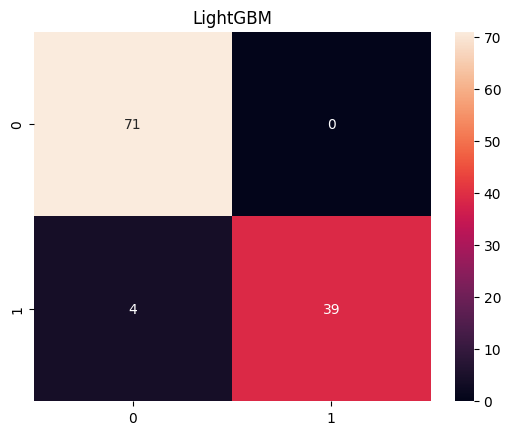

In [14]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True)
plt.title("LightGBM")
pass

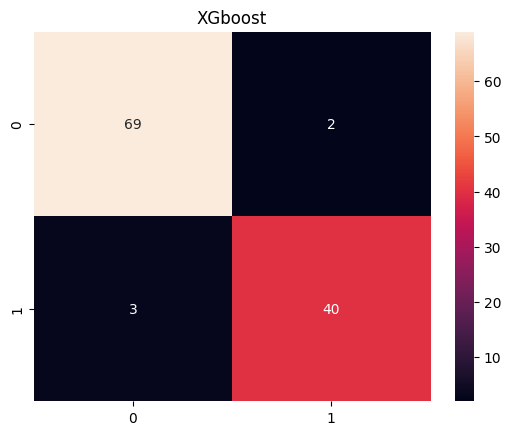

In [15]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True)
plt.title("XGboost")
pass

In [16]:
################
#SUMMARY
print("################################################")
print("# LGBM execution time is: ", execution_time_lgbm)
print("# XGBoost execution time is: ", execution_time_xgb)
difference_in_seconds = (execution_time_xgb - execution_time_lgbm).total_seconds()
print("# Gain: ", difference_in_seconds)
print("################################################")
print ("# Accuracy with LGBM = ", round(metrics.accuracy_score(y_pred_lgbm,y_test) * 100, 2))
print ("# Accuracy with XGBoost= ", round(metrics.accuracy_score(y_pred_xgb, y_test) * 100, 2))
print("# gain :", round(metrics.accuracy_score(y_pred_lgbm,y_test) * 100 - metrics.accuracy_score(y_pred_xgb, y_test) * 100, 2))
print("################################################")
print("# AUC score with LGBM is: ", round(roc_auc_score(y_pred_lgbm,y_test) * 100, 2))
print("# AUC score with XGBoost is: ", round(roc_auc_score(y_pred_xgb, y_test) * 100, 2))
print("# gain :", round(roc_auc_score(y_pred_lgbm,y_test) * 100 - roc_auc_score(y_pred_xgb, y_test) * 100, 2))
print("################################################")

################################################
# LGBM execution time is:  0:00:00.414839
# XGBoost execution time is:  0:00:00.169261
# Gain:  -0.245578
################################################
# Accuracy with LGBM =  96.49
# Accuracy with XGBoost=  95.61
# gain : 0.88
################################################
# AUC score with LGBM is:  97.33
# AUC score with XGBoost is:  95.54
# gain : 1.8
################################################


___
## Exercice avec le dataset "wine"

In [17]:
___
## Exercice avec le

,Unnamed: 0,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
